<a href="https://colab.research.google.com/github/Feilusun/QM2/blob/main/Text_Analysis_%26_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-dde0a753c158>:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=10, random_state=42) if len(x) >= 10 else x)


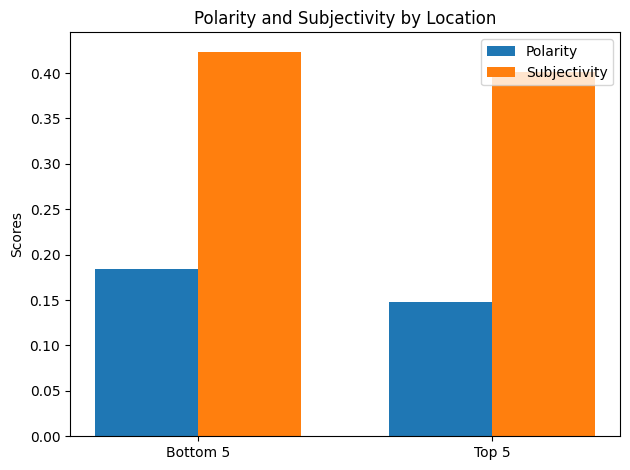

In [ ]:
import os
import re
import pandas as pd
from textblob import TextBlob
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to extract and clean text from txt files
def extract_and_clean_text_from_txt(file_path, party, location):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file at {file_path} does not exist. Please check the path.")

    data = []
    current_speaker = None

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()

            # Check for speaker/constituency pattern (e.g., "Seema Kennedy (7 May 2015~):")
            match = re.match(r"^(.*?):\s*$", line)
            if match:
                current_speaker = match.group(1)
            elif current_speaker and line:
                # Add cleaned text to the list with speaker/context
                data.append({"speaker": current_speaker, "text": line, "party": party, "location": location})

    return pd.DataFrame(data)

# Define file paths and check their existence
top5_file = 'Top5.txt'
bottom5_file = 'Bottom5.txt'

# Provide a fallback or prompt user to ensure files exist
if not os.path.exists(top5_file):
    raise FileNotFoundError(f"The file {top5_file} is missing. Ensure the file is uploaded to the correct directory.")
if not os.path.exists(bottom5_file):
    raise FileNotFoundError(f"The file {bottom5_file} is missing. Ensure the file is uploaded to the correct directory.")

# Load and clean text data from txt files
top5_data = extract_and_clean_text_from_txt(top5_file, 'Conservative', 'Top 5')
bottom5_data = extract_and_clean_text_from_txt(bottom5_file, 'Labour', 'Bottom 5')

# Combine datasets
data = pd.concat([top5_data, bottom5_data], ignore_index=True)

# Function to analyze polarity and subjectivity
def analyze_text(text):
    blob = TextBlob(text)
    return blob.polarity, blob.subjectivity

# Apply text analysis
data[['polarity', 'subjectivity']] = data['text'].apply(lambda x: pd.Series(analyze_text(x)))

# Group data by location and sample 10 texts per group
sampled_data = (
    data.groupby(['location'], group_keys=False)
    .apply(lambda x: x.sample(n=10, random_state=42) if len(x) >= 10 else x)
)

import matplotlib.pyplot as plt
import numpy as np

# Use sampled_data instead of location_stats
locations = sampled_data['location'].unique() # Get unique locations
# Calculate mean polarity and subjectivity for each location
location_stats = sampled_data.groupby('location')[['polarity', 'subjectivity']].mean().reset_index()


polarity = location_stats['polarity']
subjectivity = location_stats['subjectivity']

x = np.arange(len(locations))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, polarity, width, label='Polarity')
rects2 = ax.bar(x + width/2, subjectivity, width, label='Subjectivity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Polarity and Subjectivity by Location')
ax.set_xticks(x)
ax.set_xticklabels(locations)
ax.legend()

fig.tight_layout()


plt.show()




In [ ]:
!pip install spacy scattertext
!python -m spacy download en_core_web_sm

import spacy
import scattertext as st
import pandas as pd
from IPython.core.display import HTML

nlp = spacy.load("en_core_web_sm")

def custom_parser(text):
    doc = nlp(text)
    parsed_text = ' '.join([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'PROPN'] and not token.is_stop])
    return parsed_text

# Assuming top5_data and bottom5_data are already loaded

combined_data = pd.concat([top5_data, bottom5_data], ignore_index=True)
combined_data['category'] = combined_data['location'].map({'Top 5': 'top5', 'Bottom 5': 'bottom5'})
combined_data['parsed_text'] = combined_data['text'].apply(custom_parser)

corpus = st.CorpusFromPandas(
    combined_data,
    category_col='category',
    text_col='parsed_text',
    nlp=nlp
).build()

html = st.produce_scattertext_explorer(
    corpus,
    category='top5',
    category_name='Top 5',
    not_category_name='Bottom 5',
    minimum_term_frequency=5,
    width_in_pixels=1000,
)

HTML(html)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.6 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=0ad840b3cdc2b0d2a0abe0ce8a9ea6543ead57f2d9e0d167e774e046631bbcd4
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
